In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import pyro.distributions as dist

from scipy.io import loadmat
from scipy.stats import ttest_1samp, mannwhitneyu
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
# import pickle
import jsonpickle as pickle
import json
import gc
from statannotations.Annotator import Annotator

In [3]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")
model_comp_folder = os.path.join(results_folder, "model_comparison")

processed_data_folder = os.path.join("processed_data")

non_fit_fname = "non_fit_file.txt"
non_fit_file = os.path.join(model_comp_folder, non_fit_fname)

mask_file_name = "mask.pkl"
mask_file = os.path.join(processed_data_folder, mask_file_name)

Rho_fname = "Rho.pkl"
Rho_file = os.path.join(processed_data_folder, Rho_fname)

agent_data_fname = "data_formatted_for_agent.pkl"
agent_data_file = os.path.join(processed_data_folder, agent_data_fname)

n_agents = 24

In [4]:
trials =  272#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, 'r') as infile:
    loaded = json.load(infile)
all_mask = pickle.decode(loaded)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask)#.permute((1,0))
# exp mask knows the subject specific lengths
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.7390)


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [6]:
def convert_data_for_agent(data):

    data_obs = torch.stack([torch.from_numpy(d["observations"]) for d in data], dim=-1)
    data_rew = torch.stack([torch.from_numpy(d["rewards"]) for d in data], dim=-1)
    data_act = torch.stack([torch.from_numpy(d["actions"]) for d in data], dim=-1)
    data_val = torch.cat([torch.from_numpy(d["valid"]) for d in data], dim=-1)
    data_ind = torch.stack([torch.from_numpy(d["subject"]) for d in data], dim=-1)

    structured_data = {"subject": data_ind, "observations": data_obs, "rewards": data_rew, "actions": data_act, "valid": data_val}

    return structured_data

In [7]:
with open(agent_data_file, 'r') as infile:
    loaded = json.load(infile)
full_data = pickle.decode(loaded)

n_agents = len(full_data)
print("n subjects", n_agents)

data = convert_data_for_agent(full_data)

print(data)

n subjects 24
{'subject': tensor([[ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        ...,
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23],
        [ 0,  1,  2,  ..., 21, 22, 23]]), 'observations': tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 2,  1,  1,  ...,  1,  1,  1],
         [ 4,  3,  3,  ...,  3,  3,  3]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  1,  ...,  1,  1,  2],
         [ 3,  3,  3,  ...,  3,  3,  4]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 2,  1,  1,  ...,  1,  1,  1],
         [ 4,  5,  3,  ...,  3,  3,  3]],

        ...,

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]],

        [[-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  

In [8]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [9]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [10]:
def calculate_log_likelihood(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter

    n_agents = data["actions"].shape[-1]
    log_like = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                log_like += torch.log(masked_probs)

    return log_like
    

In [11]:
def calculate_BIC(data, agent, locs_df, npars, trials, T):

    # use bic to circumvent the number of trials problem

    n_agents = data["actions"].shape[-1]
    BIC = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor(0.5))

                print(masked_probs.shape)

                BIC -= 2*torch.log(masked_probs)

    # question: is it noraml that the first term of the BIC (k*ln(n)) is much smaller than the second (-2*ln(L))?
    BIC += npars*torch.log(data["valid"].sum(axis=0))

    return BIC
    

In [12]:
def calculate_lppd(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (4,5) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average likelihood

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)

    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    mean_log_like = torch.log(mean_like).sum(dim=0)

    #print(mean_log_like)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    return mean_log_like.clone().detach()
    

In [13]:
def calculate_waic(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (12,13) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average WAIC
    # are the larger number of params handled correctly?

    n_agents = data["actions"].shape[-1]
    
    locs_list = []25
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)



    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like_samples = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    lppd = torch.log(mean_like_samples).sum(dim=0)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    mean_log_like_samples = torch.log(mean_like.sum(dim=-2)) / n_samples

    V_s = ((torch.log(mean_like) - mean_log_like_samples[:,None,:])**2).sum(dim=-2) / (n_samples-1)

    p_waic = V_s.sum(dim=0)

    ellp_waic = lppd - p_waic

    # text says it needs to be -2 * eq 13.
    # minus is required to make lower better, and the 2 converts it to variance scale

    return ellp_waic.clone().detach()
    

In [14]:
def predictive_accuracy_mean_param(data, agent, locs_df, npars, trials, T):

    n_agents = data["actions"].shape[-1]

    predicted_accuracy = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:
                #print(tau,t)

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]#*data["valid"][tau].long()
                #print(curr_response)

                predicted_response = torch.argmax(probs, dim=0)[0]

                #print(probs)

                #print(predicted_response)

                correct_response_predicted = (curr_response == predicted_response).int()

                #print(correct_response_predicted)

                predicted_accuracy += correct_response_predicted

                num_valid_responses += data["valid"][tau]

                #print(num_valid_responses)


    corrected_predicted_accuracy = predicted_accuracy / num_valid_responses

    return corrected_predicted_accuracy

In [15]:
def calculate_exceedance_prob(measure, n_exc_samples=500):
    
    p_model = torch.nn.functional.softmax(measure, dim=-1)

    print("p model mean according to measure", p_model.mean(dim=0))

    dirichlet_counts = p_model.sum(dim=0)

    model_prob_dirichlet = dist.Dirichlet(dirichlet_counts)

    n_exc_samples = 500

    dir_samples = model_prob_dirichlet.sample(sample_shape=torch.tensor([n_exc_samples]))

    avg_best_model = dir_samples.mean(dim=0).argmax()

    best_model = dir_samples.argmax(dim=1)

    exc_prob = (best_model == avg_best_model).sum()/n_exc_samples

    print("best model:", avg_best_model, "exceedance prob", exc_prob)

    significant_best_model = ttest_1samp(dir_samples[:,avg_best_model], 1./measure.shape[-1], alternative="greater")

    print("is significantly different from uniform?", significant_best_model)

    return exc_prob, avg_best_model

BCC_3param_inference_
analyzing 24 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/FeherDaSilva_magic_carpet_data/../code/BalancingControl/perception.py:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

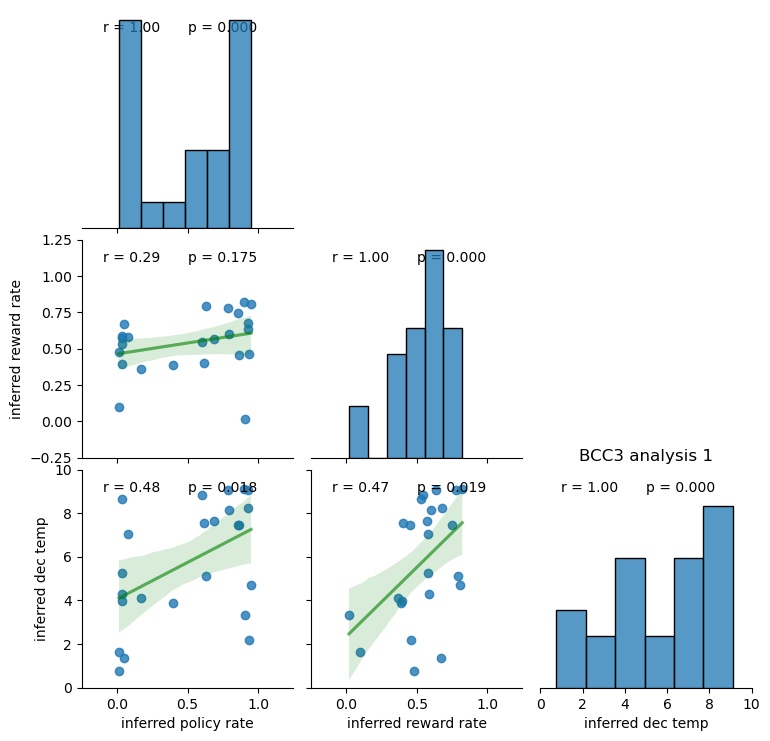

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_3param) with 24 agents.
The settings are: infer h False


In [16]:
# BCC3 analysis 1

infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC3_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC3_1_mean_df, BCC3_1_sample_df, BCC3_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_1_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [17]:
# calculate agent log likelihood using mean params

BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

BCC3_params = torch.stack([torch.tensor(BCC3_1_mean_df["inferred "+name]) for name in param_names], dim=-1)


BCC3_log_like = -calculate_log_likelihood(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC3_BIC = calculate_BIC(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC3_lppd = -calculate_lppd(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_WAIC = -calculate_waic(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_log_like, "type": ["log likelihood"]*n_agents, "model": ["BCC3"]*n_agents})
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_lppd, "type": ["lppd"]*n_agents, "model": ["BCC3"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_BIC, "type": ["BIC"]*n_agents, "model": ["BCC3"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_WAIC, "type": ["WAIC"]*n_agents, "model": ["BCC3"]*n_agents})])

print("BCC3 log like", BCC3_log_like.mean())

print("BCC3 BIC", BCC3_BIC.mean())

print("BCC3 lppd", BCC3_lppd.mean())

gc.collect()

torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24

2471

BCC_4param_inference_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

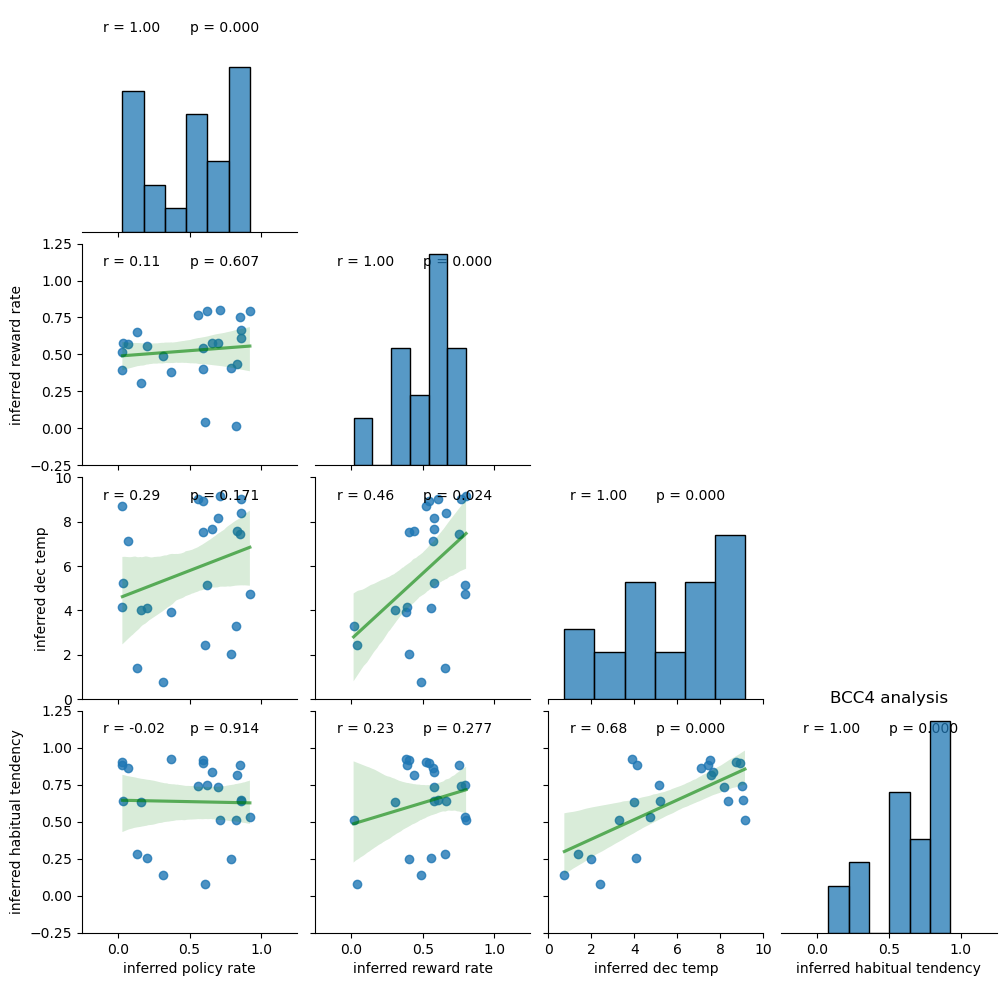

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_4param) with 24 agents.
The settings are: infer h True


In [18]:
# BCC4

infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC4_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_mean_df, BCC4_sample_df, BCC4_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

BCC_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [19]:
# calculate agent log likelihood using mean params

BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

BCC4_params = torch.stack([torch.tensor(BCC4_mean_df["inferred "+name]) for name in param_names], dim=-1)
print(BCC4_sample_df.keys())

BCC4_log_like = -calculate_log_likelihood(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC4_BIC = calculate_BIC(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC4_lppd = -calculate_lppd(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_WAIC = -calculate_waic(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_log_like, "type": ["log likelihood"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_lppd, "type": ["lppd"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_BIC, "type": ["BIC"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_WAIC, "type": ["WAIC"]*n_agents, "model": ["BCC4"]*n_agents})])

print("BCC4 log like", BCC4_log_like.mean())

print("BCC4 BIC", BCC4_BIC.mean())

print("BCC4 lppd", BCC4_lppd.mean())

gc.collect()

Index(['Unnamed: 0', 'policy rate', 'reward rate', 'dec temp',
       'habitual tendency', 'subject'],
      dtype='object')
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Si

1406

In [20]:
print(measures_df)

    subject     measure            type model
0         0  351.765564  log likelihood  BCC3
1         1  376.888824  log likelihood  BCC3
2         2  318.736206  log likelihood  BCC3
3         3  328.784607  log likelihood  BCC3
4         4  320.610443  log likelihood  BCC3
..      ...         ...             ...   ...
19       19  623.877136            WAIC  BCC4
20       20  656.981445            WAIC  BCC4
21       21  655.932373            WAIC  BCC4
22       22  663.876587            WAIC  BCC4
23       23  602.991760            WAIC  BCC4

[192 rows x 4 columns]


/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

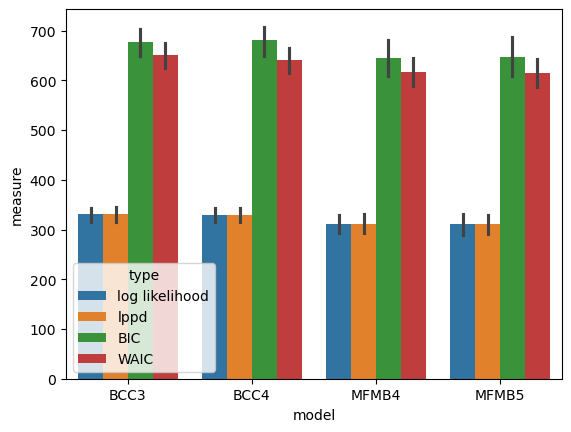

In [60]:
# plot differences in fit for BCC model

plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.show()

mbmf_4param_inference_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

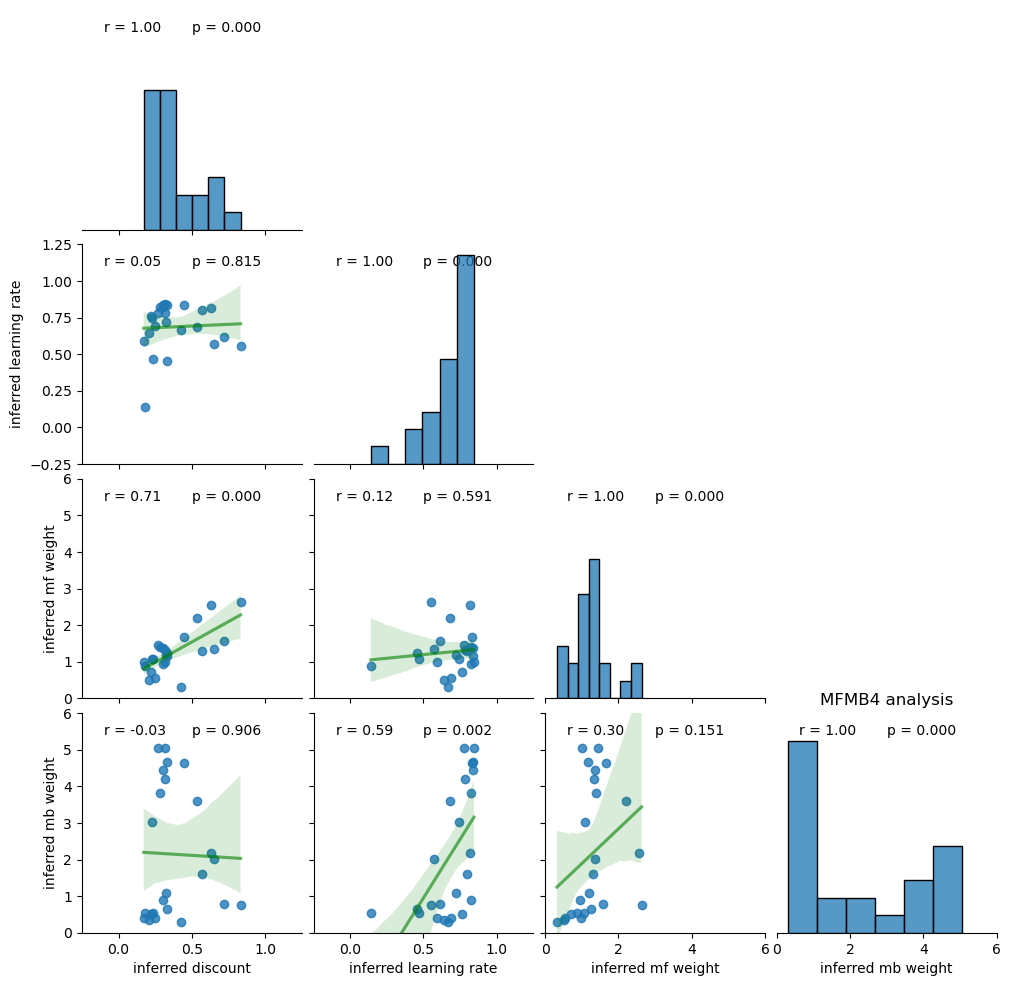

This is inference for the twostage task using the two beta mbmf model(mbmf_4param) with 24 agents.
The settings are: use p False


In [61]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB4_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB4_mean_df, MFMB4_sample_df, MFMB4_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [23]:
# calculate agent log likelihood using mean params

MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)
MFMB4_params = torch.stack([torch.tensor(MFMB4_mean_df["inferred "+name]) for name in param_names], dim=-1)


MFMB4_log_like = -calculate_log_likelihood(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB4_BIC = calculate_BIC(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB4_lppd = -calculate_lppd(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_WAIC = -calculate_waic(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_log_like, "type": ["log likelihood"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_lppd, "type": ["lppd"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_BIC, "type": ["BIC"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_WAIC, "type": ["WAIC"]*n_agents, "model": ["MFMB4"]*n_agents})])

print("MFMB4 log like", MFMB4_log_like.mean())

print("MFMB4 BIC", MFMB4_BIC.mean())

gc.collect()

torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24

48797

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

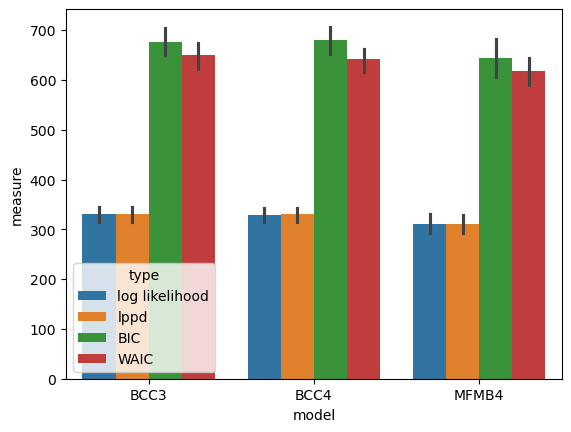

In [24]:
plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.show()

mbmf_5param_inference_
analyzing 24 data sets


<Figure size 640x480 with 0 Axes>

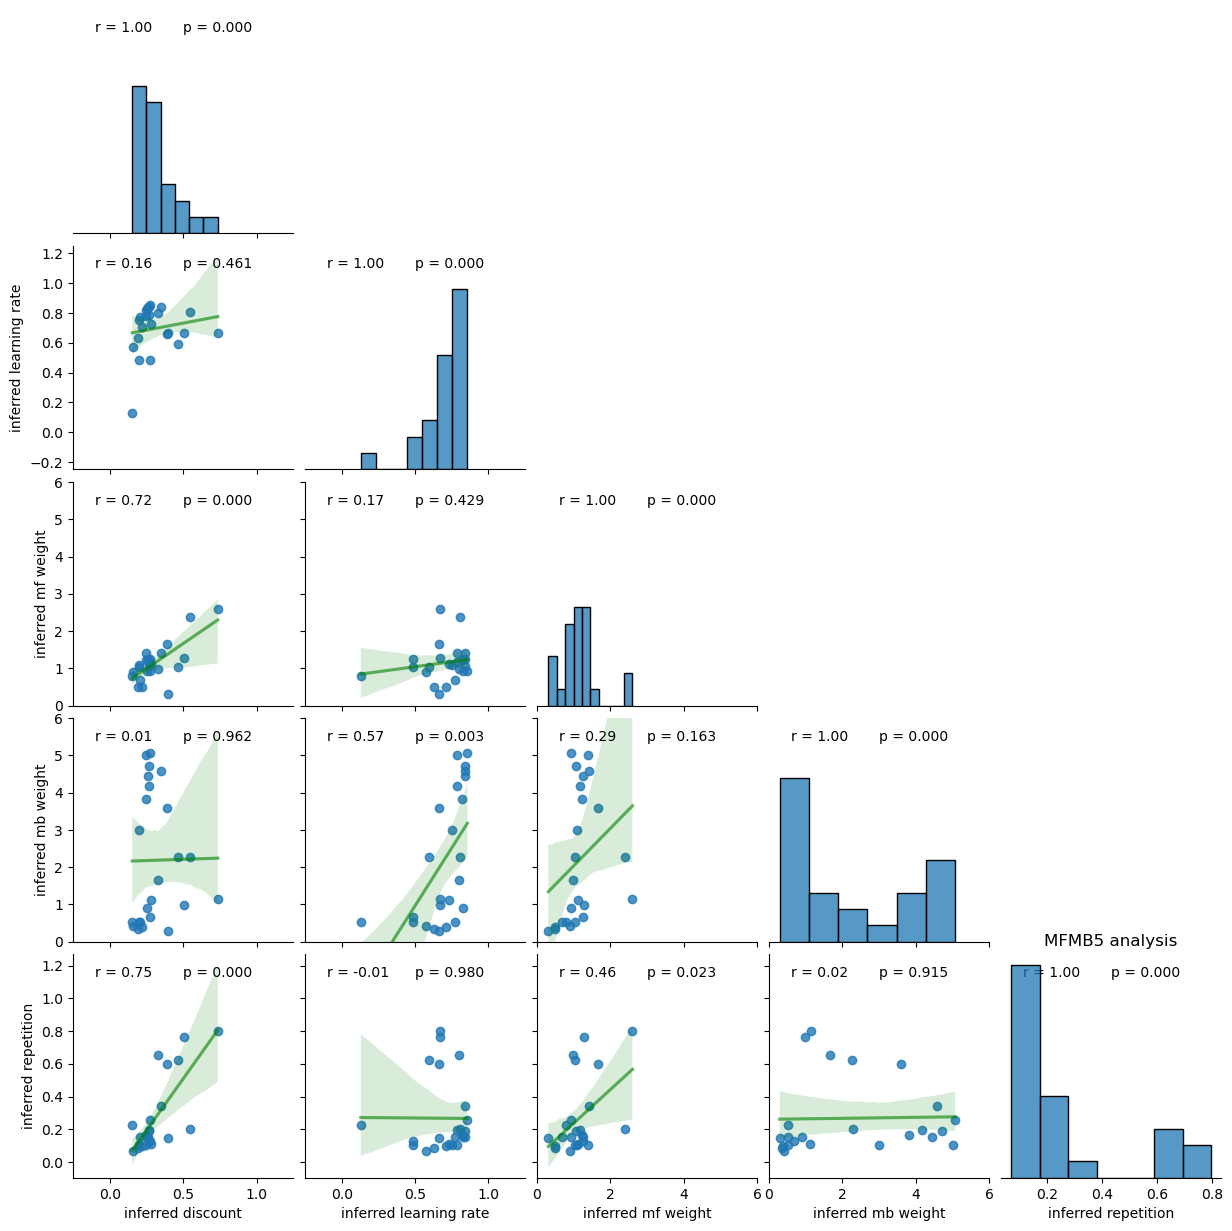

This is inference for the twostage task using the two beta mbmf model(mbmf_5param) with 24 agents.
The settings are: use p True


In [25]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB5_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB5_mean_df, MFMB5_sample_df, MFMB5_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [26]:
# calculate agent log likelihood using mean params

MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)
MFMB5_params = torch.stack([torch.tensor(MFMB5_mean_df["inferred "+name]) for name in param_names], dim=-1)


MFMB5_log_like = -calculate_log_likelihood(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB5_BIC = calculate_BIC(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB5_lppd = -calculate_lppd(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_WAIC = -calculate_waic(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_log_like, "type": ["log likelihood"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_lppd, "type": ["lppd"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_BIC, "type": ["BIC"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_WAIC, "type": ["WAIC"]*n_agents, "model": ["MFMB5"]*n_agents})])

print("MFMB5 log like", MFMB5_log_like.mean())

print("MFMB5 BIC", MFMB5_BIC.mean())

gc.collect()

torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24])
torch.Size([24

54996

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

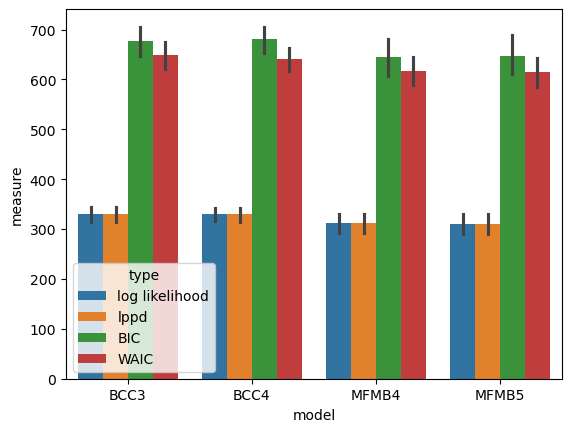

In [27]:
plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.savefig(os.path.join(model_comp_folder, "model_comparison.svg"))
plt.savefig(os.path.join(model_comp_folder, "model_comparison.png"))
plt.show()

In [62]:
with open(non_fit_file, "r") as f:
    all_didnt_fit = json.load(f)

did_fit = torch.ones(n_agents).bool()
did_fit[all_didnt_fit] = False

print(did_fit.sum())

tensor(22)


In [63]:
all_total_log_likes = torch.stack([BCC3_log_like, BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)

winning_model = all_total_log_likes.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

all_log_likes_exc_prob, all_log_likes_avg_best_model = calculate_exceedance_prob(-all_total_log_likes)

BCC3 wins tensor(0)
BCC4 wins tensor(6)
MFMB4 wins tensor(4)
MFMB5 wins tensor(14)
p model mean according to measure tensor([0.0460, 0.2072, 0.2434, 0.5035])
best model: tensor(3) exceedance prob tensor(0.8960)
is significantly different from uniform? TtestResult(statistic=54.52442437612002, pvalue=1.228447987373473e-212, df=499)


In [64]:
all_total_log_likes_did_fit = torch.stack([BCC3_log_like, BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = all_total_log_likes_did_fit.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

all_log_likes_exc_prob_did_fit, all_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-all_total_log_likes_did_fit)

BCC3 wins tensor(0)
BCC4 wins tensor(5)
MFMB4 wins tensor(4)
MFMB5 wins tensor(13)
p model mean according to measure tensor([0.0482, 0.1656, 0.2553, 0.5309])
best model: tensor(3) exceedance prob tensor(0.9100)
is significantly different from uniform? TtestResult(statistic=59.3031524363623, pvalue=2.0585454806692843e-228, df=499)


In [65]:
BCC4_MFMB4_total_log_likes = torch.stack([BCC4_log_like, MFMB4_log_like], dim=-1)

winning_model = BCC4_MFMB4_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_log_likes_exc_prob, BCC4_MFMB4_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB4_total_log_likes)

BCC4 wins tensor(8)
MFMB4 wins tensor(16)
p model mean according to measure tensor([0.2920, 0.7080])
best model: tensor(1) exceedance prob tensor(0.9840)
is significantly different from uniform? TtestResult(statistic=50.63162297561679, pvalue=4.875588952197637e-199, df=499)


In [66]:
BCC4_MFMB4_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB4_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_log_likes_exc_prob_did_fit, BCC4_MFMB4_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB4_total_log_likes_did_fit)

BCC4 wins tensor(6)
MFMB4 wins tensor(16)
p model mean according to measure tensor([0.2445, 0.7555])
best model: tensor(1) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=62.247995634206305, pvalue=1.1463040560265609e-237, df=499)


In [67]:
BCC4_MFMB5_total_log_likes = torch.stack([BCC4_log_like, MFMB5_log_like], dim=-1)

winning_model = BCC4_MFMB5_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

BCC4_MFMB5_log_likes_exc_prob, BCC4_MFMB5_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB5_total_log_likes)

BCC4 wins tensor(6)
MFMB5 wins tensor(18)
p model mean according to measure tensor([0.2648, 0.7352])
best model: tensor(1) exceedance prob tensor(0.9960)
is significantly different from uniform? TtestResult(statistic=64.72263912941358, pvalue=3.468918260065916e-245, df=499)


In [68]:
BCC4_MFMB5_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB5_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_log_likes_exc_prob_did_fit, BCC4_MFMB5_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB5_total_log_likes_did_fit)

BCC4 wins tensor(5)
MFMB4 wins tensor(17)
p model mean according to measure tensor([0.2214, 0.7786])
best model: tensor(1) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=71.56065405987152, pvalue=7.762965792224123e-265, df=499)


In [69]:
BCC4_MFMB4_MFMB5_total_log_likes = torch.stack([BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)

winning_model = BCC4_MFMB4_MFMB5_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_log_likes_exc_prob, BCC4_MFMB4_MFMB5_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB4_MFMB5_total_log_likes)

BCC4 wins tensor(6)
MFMB4 wins tensor(4)
MFMB5 wins tensor(14)
p model mean according to measure tensor([0.2490, 0.2461, 0.5049])
best model: tensor(2) exceedance prob tensor(0.8780)
is significantly different from uniform? TtestResult(statistic=38.427264463105374, pvalue=1.6246113779999028e-151, df=499)


In [70]:
BCC4_MFMB4_MFMB5_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_MFMB5_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_log_likes_exc_prob_did_fit, BCC4_MFMB4_MFMB5_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB4_MFMB5_total_log_likes_did_fit)

print((winning_model==0).sum()/n_agents)

BCC4 wins tensor(5)
MFMB4 wins tensor(4)
MFMB5 wins tensor(13)
p model mean according to measure tensor([0.2094, 0.2581, 0.5325])
best model: tensor(2) exceedance prob tensor(0.9140)
is significantly different from uniform? TtestResult(statistic=42.35716385393847, pvalue=1.1320144660750572e-167, df=499)
tensor(0.2083)


In [71]:
all_total_WAICs = torch.stack([BCC3_WAIC, BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

all_WAICs_exc_prob, all_WAICs_avg_best_model = calculate_exceedance_prob(-2*all_total_WAICs)

BCC3 wins tensor(0)
BCC4 wins tensor(9)
MFMB4 wins tensor(7)
MFMB5 wins tensor(8)
torch.Size([24, 4])
tensor([0.0010, 0.3704, 0.3066, 0.3220])
tensor([0.0000e+00, 0.0000e+00, 1.0602e-40, 1.0000e+00])
p model mean according to measure tensor([0.0010, 0.3704, 0.3066, 0.3220])
best model: tensor(1) exceedance prob tensor(0.4700)
is significantly different from uniform? TtestResult(statistic=27.44058609847674, pvalue=4.858631730035953e-102, df=499)


In [72]:
all_total_WAICs_did_fit = torch.stack([BCC3_WAIC, BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = all_total_WAICs_did_fit.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*all_total_WAICs_did_fit, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*all_total_WAICs_did_fit.sum(dim=0), dim=-1)

print(p_model_total)

all_WAICs_exc_prob_did_fit, all_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*all_total_WAICs)

BCC3 wins tensor(0)
BCC4 wins tensor(7)
MFMB4 wins tensor(7)
MFMB5 wins tensor(8)
torch.Size([22, 4])
tensor([0.0011, 0.3132, 0.3344, 0.3513])
tensor([0.0000e+00, 0.0000e+00, 5.1478e-40, 1.0000e+00])
p model mean according to measure tensor([0.0010, 0.3704, 0.3066, 0.3220])
best model: tensor(1) exceedance prob tensor(0.4760)
is significantly different from uniform? TtestResult(statistic=26.918181035148372, pvalue=1.4992672691760606e-99, df=499)


In [73]:
BCC4_MFMB4_total_WAICs = torch.stack([BCC4_WAIC, MFMB4_WAIC], dim=-1)

winning_model = BCC4_MFMB4_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_WAICs_exc_prob, BCC4_MFMB4_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB4_total_WAICs)

BCC4 wins tensor(9)
MFMB4 wins tensor(15)
p model mean according to measure tensor([0.3714, 0.6286])
best model: tensor(1) exceedance prob tensor(0.8940)
is significantly different from uniform? TtestResult(statistic=28.068220129879396, pvalue=5.112281793336597e-105, df=499)


In [74]:
BCC4_MFMB4_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB4_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_WAICs_exc_prob_did_fit, BCC4_MFMB4_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB4_total_WAICs_did_fit)

BCC4 wins tensor(7)
MFMB4 wins tensor(15)
p model mean according to measure tensor([0.3143, 0.6857])
best model: tensor(1) exceedance prob tensor(0.9600)
is significantly different from uniform? TtestResult(statistic=41.87174894986096, pvalue=1.0100604700399013e-165, df=499)


In [75]:
BCC4_MFMB5_total_WAICs = torch.stack([BCC4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = BCC4_MFMB5_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_WAICs_exc_prob, BCC4_MFMB5_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB5_total_WAICs)

BCC4 wins tensor(9)
MFMB4 wins tensor(15)
p model mean according to measure tensor([0.3753, 0.6247])
best model: tensor(1) exceedance prob tensor(0.8780)
is significantly different from uniform? TtestResult(statistic=27.059152833721008, pvalue=3.1856620775801876e-100, df=499)


In [76]:
BCC4_MFMB5_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB5_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_WAICs_exc_prob_did_fit, BCC4_MFMB5_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB5_total_WAICs_did_fit)

BCC4 wins tensor(7)
MFMB4 wins tensor(15)
p model mean according to measure tensor([0.3185, 0.6815])
best model: tensor(1) exceedance prob tensor(0.9660)
is significantly different from uniform? TtestResult(statistic=42.77926100881328, pvalue=2.3336211559197943e-169, df=499)


In [77]:
BCC4_MFMB4_MFMB5_total_WAICs = torch.stack([BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = BCC4_MFMB4_MFMB5_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_WAICs_exc_prob, BCC4_MFMB4_MFMB5_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB4_MFMB5_total_WAICs)

BCC4 wins tensor(9)
MFMB4 wins tensor(7)
MFMB5 wins tensor(8)
p model mean according to measure tensor([0.3714, 0.3066, 0.3220])
best model: tensor(0) exceedance prob tensor(0.4820)
is significantly different from uniform? TtestResult(statistic=8.714321921493239, pvalue=2.168086217292937e-17, df=499)


In [78]:
BCC4_MFMB4_MFMB5_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_MFMB5_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_WAICs_exc_prob_did_fit, BCC4_MFMB4_MFMB5_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB4_MFMB5_total_WAICs_did_fit)

print((winning_model==0).sum()/n_agents)

BCC4 wins tensor(7)
MFMB4 wins tensor(7)
MFMB5 wins tensor(8)
p model mean according to measure tensor([0.3143, 0.3344, 0.3513])
best model: tensor(2) exceedance prob tensor(0.3680)
is significantly different from uniform? TtestResult(statistic=1.8600343276084415, pvalue=0.03173441808484697, df=499)
tensor(0.2917)


8
  winning model  # of participants
0          BCC4                  8
1         MFMB4                 16


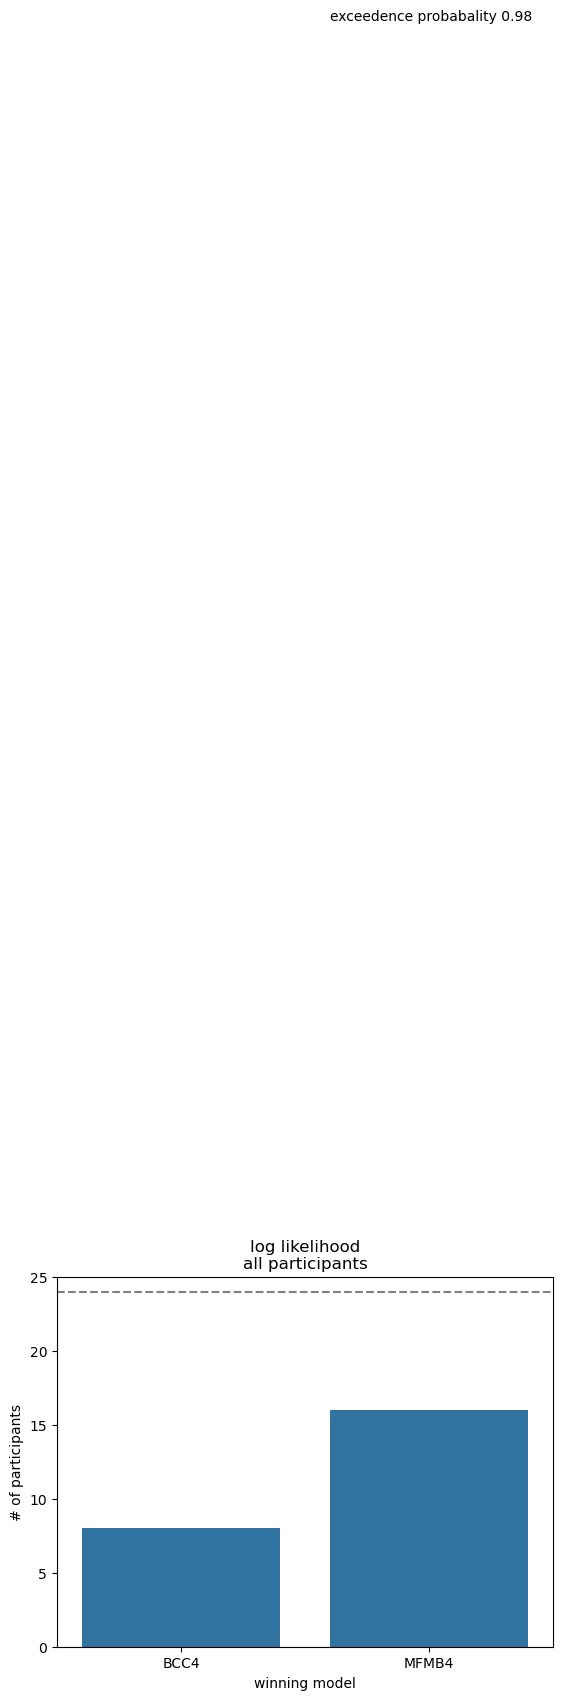

In [90]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_log_likes.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
# plt.text(1.25, 178, f"N = {n_agents}")
plt.text(0.6, 110, f"exceedence probabality {BCC4_MFMB4_log_likes_exc_prob:.2f}")
plt.ylim([0,25])
plt.title("log likelihood\nall participants")
plt.savefig(os.path.join(model_comp_folder, "exc_prob_llike_all.svg"))
plt.show()

9
  winning model  # of participants
0          BCC4                  9
1         MFMB4                 15


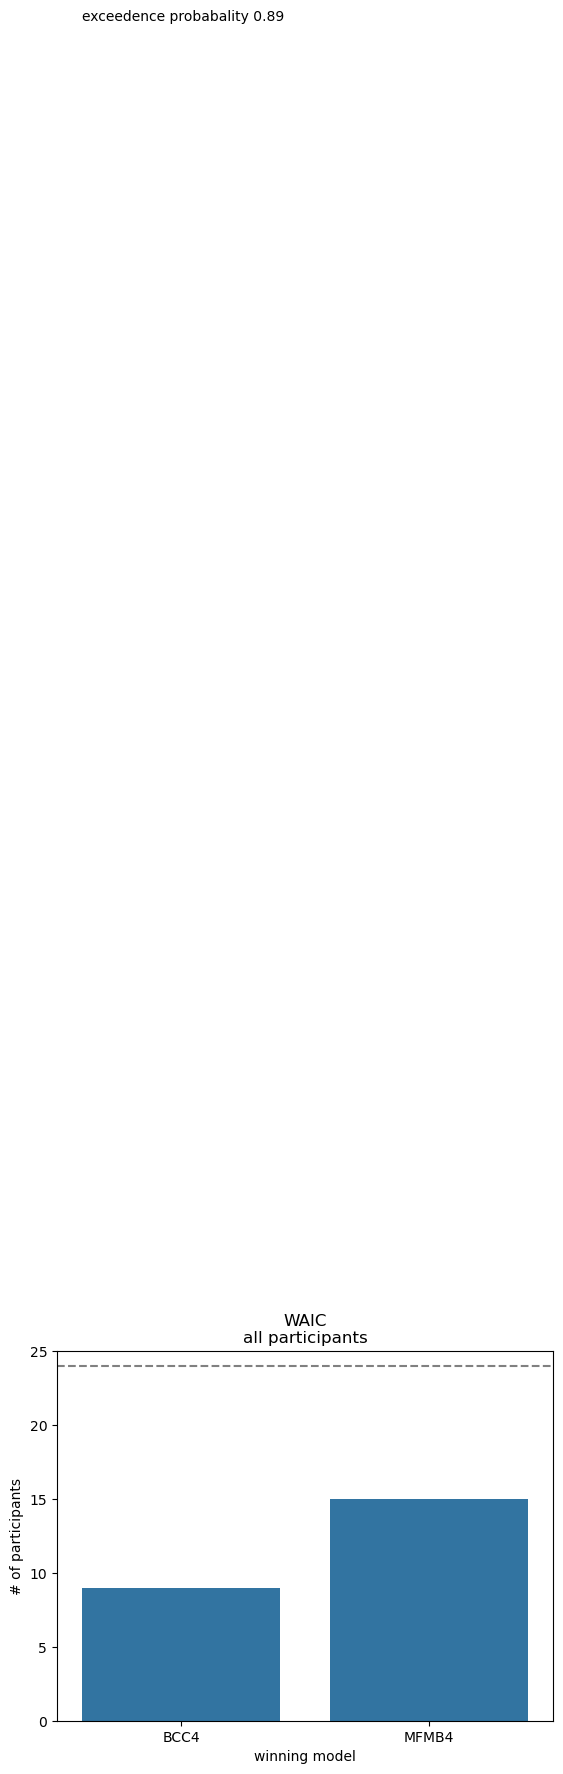

In [92]:
# plot model comparisons

plt.figure()
winning_model = BCC4_MFMB4_total_WAICs.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
# plt.text(1.25, 178, f"N = {n_agents}")
plt.text(-0.4, 115, f"exceedence probabality {BCC4_MFMB4_WAICs_exc_prob:.2f}")
plt.ylim([0,25])
plt.title("WAIC\nall participants")
plt.savefig(os.path.join(model_comp_folder, "exc_prob_waic_all.svg"))
plt.show()

6
  winning model  # of participants
0          BCC4                  6
1         MFMB4                 16


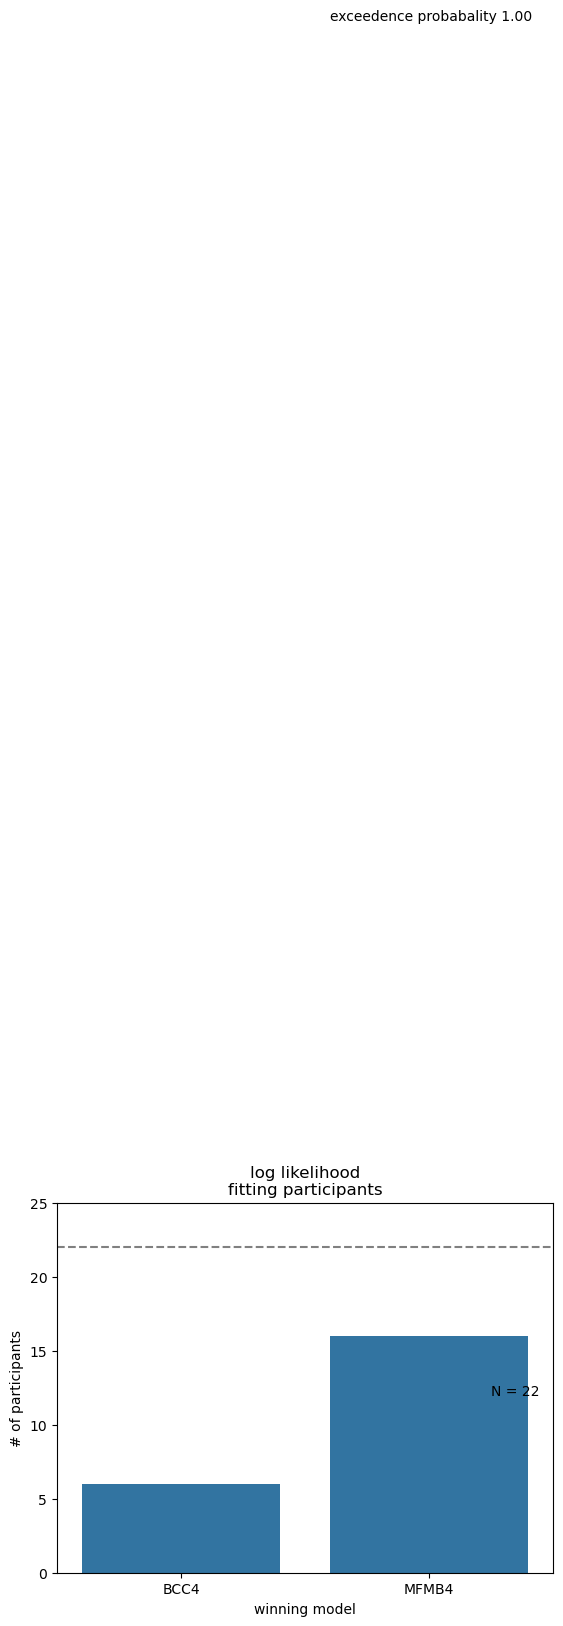

In [93]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_log_likes_did_fit.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=did_fit.sum(), color='grey', linestyle='--')
plt.text(1.25, did_fit.sum()-10, f"N = {did_fit.sum()}")
plt.text(0.6, 105, f"exceedence probabality {BCC4_MFMB4_log_likes_exc_prob_did_fit:.2f}")
plt.ylim([0,25])
plt.title("log likelihood\nfitting participants")
plt.savefig(os.path.join(model_comp_folder, "exc_prob_llike_fitting.svg"))
plt.show()

7
  winning model  # of participants
0          BCC4                  7
1         MFMB4                 15


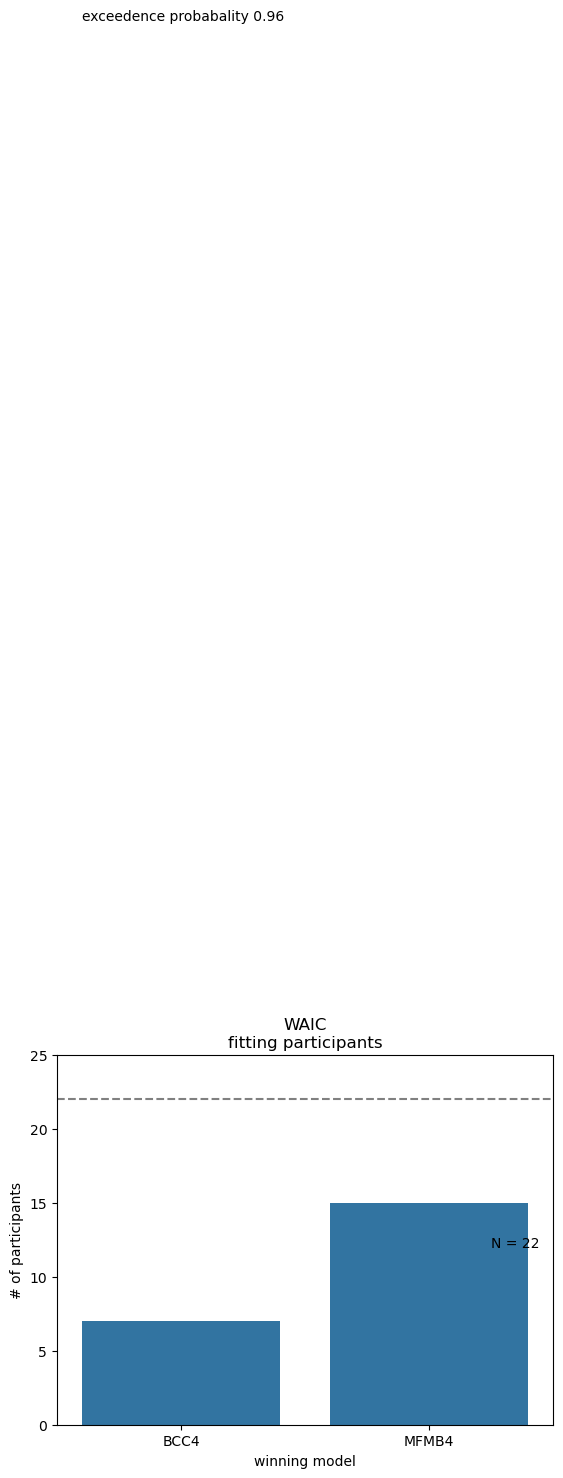

In [94]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_WAICs_did_fit.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=did_fit.sum(), color='grey', linestyle='--')
plt.text(1.25, did_fit.sum()-10, f"N = {did_fit.sum()}")
plt.text(-0.4, 95, f"exceedence probabality {BCC4_MFMB4_WAICs_exc_prob_did_fit:.2f}")
plt.ylim([0,25])
plt.title("WAIC\nfitting participants")
plt.savefig(os.path.join(model_comp_folder, "exc_prob_waic_fitting.svg"))
plt.show()

9
  winning model  # of participants
0          BCC4                  9
1         MFMB4                  7
2         MFMB5                  8


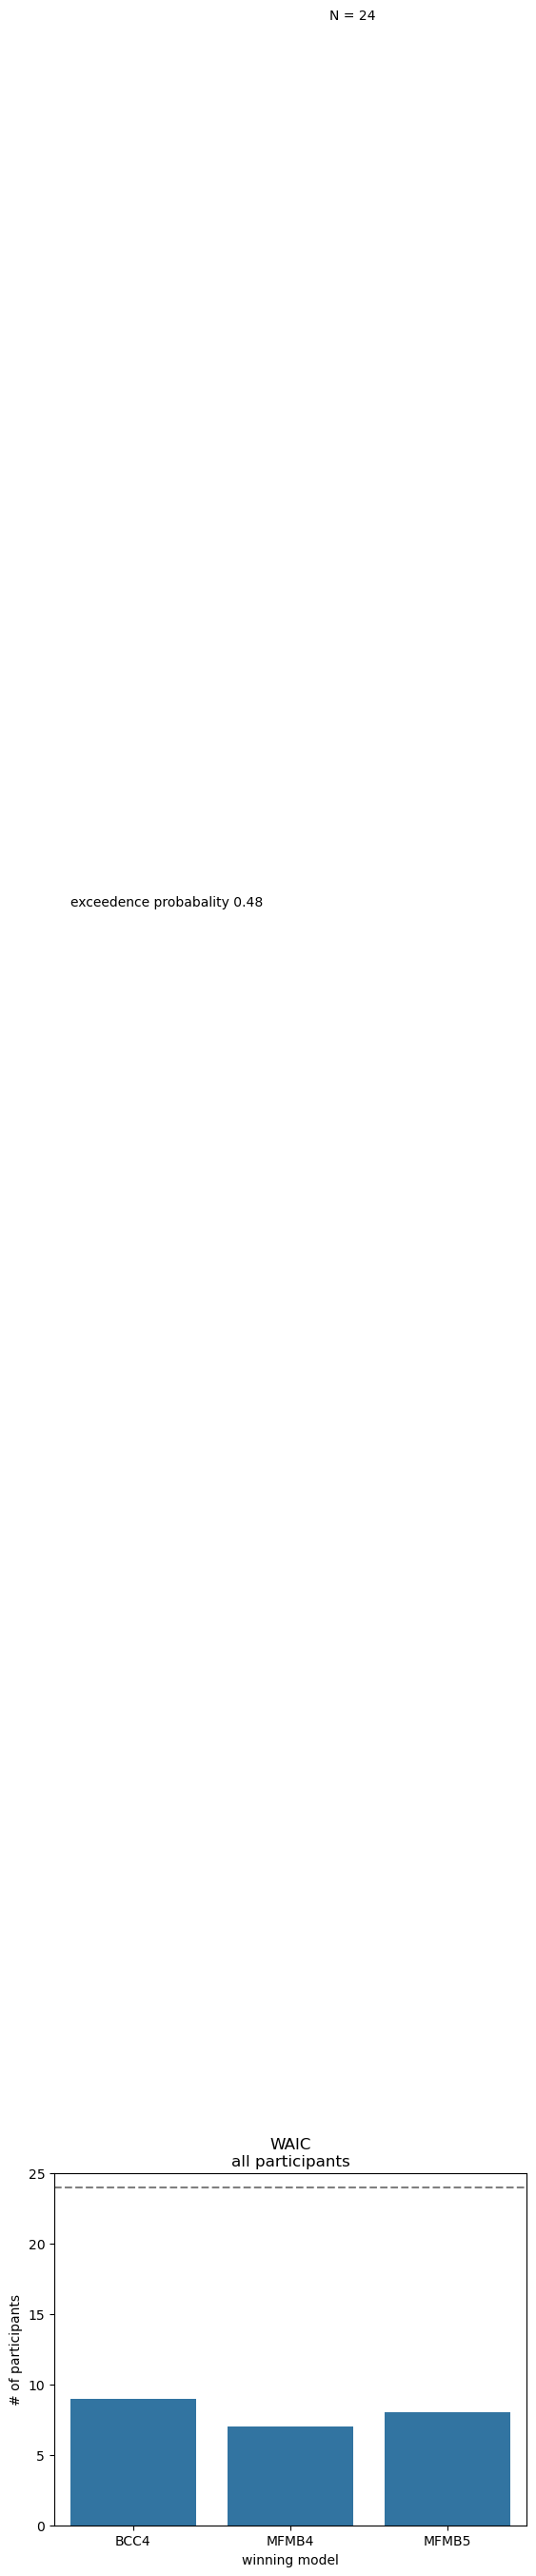

In [83]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_MFMB5_total_WAICs.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4", "MFMB5"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum(), (winning_model==2).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
plt.text(1.25, 178, f"N = {n_agents}")
plt.text(-0.4, 115, f"exceedence probabality {BCC4_MFMB4_MFMB5_WAICs_exc_prob:.2f}")
plt.ylim([0,25])
plt.title("WAIC\nall participants")
plt.show()

In [84]:
group_surely_BCC4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 0, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 0)
group_surely_MFMB4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 1, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 1)
group_log_MFMB4_WAIC_BCC4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 1, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 0)
group_log_BCC4_WAIC_MFMB4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 0, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 1)

print("all", BCC4_MFMB4_total_log_likes.shape[0], BCC4_MFMB4_total_WAICs.shape[0])
print("surely BCC4", group_surely_BCC4.sum())
print("surely MFMB4", group_surely_MFMB4.sum())
print("log MFMB4 waic BCC4", group_log_MFMB4_WAIC_BCC4.sum())
print("log BCC4 waic MFMB4", group_log_BCC4_WAIC_MFMB4.sum())

print("all", group_surely_BCC4.sum()+group_surely_MFMB4.sum()+group_log_MFMB4_WAIC_BCC4.sum()+group_log_BCC4_WAIC_MFMB4.sum())

all 24 24
surely BCC4 tensor(8)
surely MFMB4 tensor(15)
log MFMB4 waic BCC4 tensor(1)
log BCC4 waic MFMB4 tensor(0)
all tensor(24)


In [85]:
winning_model = []

for n in range(n_agents):
    if group_surely_BCC4[n]:
        winning_model.append("BCC4")
    elif group_surely_MFMB4[n]:
        winning_model.append("MFMB4")
    elif group_log_MFMB4_WAIC_BCC4[n]:
        winning_model.append("log MFMB4 WAIC BCC4")
    elif group_log_BCC4_WAIC_MFMB4[n]:
        winning_model.append("log BCC4 WAIC MFMB4")
print(winning_model)

['MFMB4', 'BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'MFMB4', 'BCC4']


In [86]:
results_mean_df = pd.concat([BCC4_mean_df, MFMB4_mean_df, pd.DataFrame({"winning model": winning_model}), pd.DataFrame({"did fit": did_fit})], axis=1)

In [87]:
results_mean_df

,Unnamed: 0,inferred policy rate,subject,inferred reward rate,inferred dec temp,inferred habitual tendency,Unnamed: 0,inferred discount,subject,inferred learning rate,inferred mf weight,inferred mb weight,winning model,did fit
0,0,0.623041,0,0.795365,5.144201,0.752142,0,0.322842,0,0.720416,1.188606,1.093261,MFMB4,True
1,1,0.789982,1,0.406411,2.012621,0.248680,1,0.224487,1,0.762027,0.713468,0.504614,BCC4,False
2,2,0.710082,2,0.802311,9.139822,0.509569,2,0.313812,2,0.844502,0.992779,5.058662,MFMB4,True
3,3,0.653445,3,0.577272,7.663825,0.835761,3,0.447972,3,0.832229,1.666133,4.631620,MFMB4,True
4,4,0.561074,4,0.763869,9.024982,0.742649,4,0.284176,4,0.822118,1.392195,3.811675,MFMB4,True
5,5,0.312290,5,0.491549,0.752466,0.138705,5,0.429038,5,0.666962,0.321491,0.293054,BCC4,True
6,6,0.031955,6,0.392091,4.132893,0.883230,6,0.180706,6,0.140573,0.873488,0.527594,log MFMB4 WAIC BCC4,True
7,7,0.920070,7,0.792900,4.744188,0.531265,7,0.302461,7,0.823497,0.948904,0.896565,MFMB4,True
8,8,0.607888,8,0.041475,2.417714,0.078584,8,0.207504,8,0.641152,0.507514,0.354125,BCC4,True
9,9,0.593638,9,0.541857,8.916680,0.900279,9,0.633262,9,0.815837,2.561521,2.178430,MFMB4,True


In [88]:
def plot_group_bars(df, variable_of_interest, fontsize=12, only_fitting=True, annotate_pvals=False):
    model_names = ["BCC4", "MFMB4", "log MFMB4 WAIC BCC4", "log BCC4 WAIC MFMB4"]

    # test and annotate

    if only_fitting:
        working_df = df[df["did fit"]==True]
    else:
        working_df = df

    if annotate_pvals:
        vals = {}
        for name in model_names:
            vals[name] = working_df[working_df["winning model"]==name]["inferred "+variable_of_interest].values

        pairs = [("BCC4", "MFMB4"),
                ("BCC4", "log MFMB4 WAIC BCC4"),
                ("BCC4", "log BCC4 WAIC MFMB4"),
                ("MFMB4", "BCC4"),
                ("MFMB4", "log MFMB4 WAIC BCC4"),
                ("MFMB4", "log BCC4 WAIC MFMB4"),
                ("log MFMB4 WAIC BCC4", "BCC4"),
                ("log MFMB4 WAIC BCC4", "MFMB4"),
                ("log MFMB4 WAIC BCC4", "log BCC4 WAIC MFMB4"),
                ("log BCC4 WAIC MFMB4", "BCC4"),
                ("log BCC4 WAIC MFMB4", "MFMB4"),
                ("log BCC4 WAIC MFMB4", "log MFMB4 WAIC BCC4"),
                ]

        stat_results = [mannwhitneyu(vals[pair[0]], vals[pair[1]], alternative="two-sided") for pair in pairs]
        
        pvalues = [result.pvalue for result in stat_results]

        sig_pairs = []
        sig_pvalues = []
        for i,pair in enumerate(pairs):
            if pvalues[i] <= 0.05:
                sig_pairs.append(pair)
                sig_pvalues.append(pvalues[i])


    # plot
    plt.figure()
    g = sns.barplot(data=working_df, x="winning model", y="inferred "+variable_of_interest)
    g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')
    plt.yticks(fontsize = fontsize)
    g.set_xlabel(g.get_xlabel(), fontsize=fontsize)
    g.set_ylabel(g.get_ylabel(), fontsize=fontsize)

    if annotate_pvals:
        ax = plt.gca()

        annotator = Annotator(ax, sig_pairs, data=working_df, x="winning model", y="inferred "+variable_of_interest)#, loc="outside")#, perform_stat_test=True)
        #annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
        #_, corrected_results = annotator.apply_and_annotate()
        annotator.set_pvalues(sig_pvalues)
        annotator.annotate()

    plt.show()

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


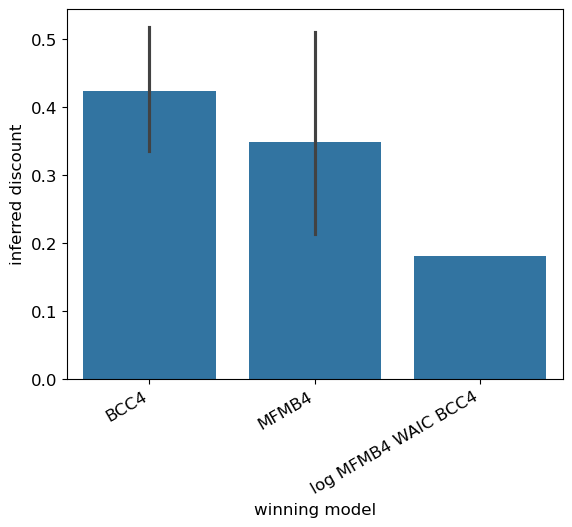

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


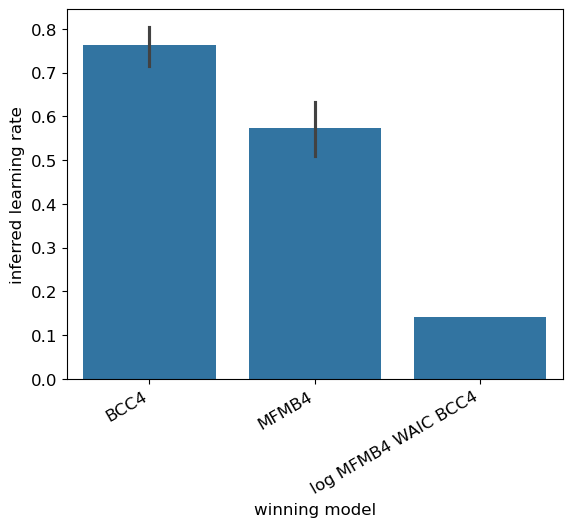

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


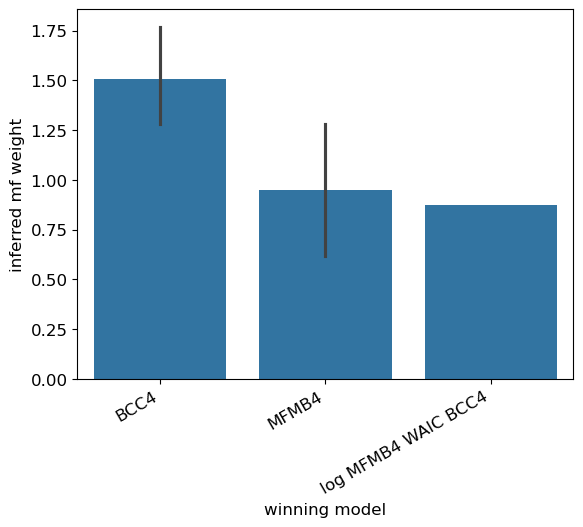

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


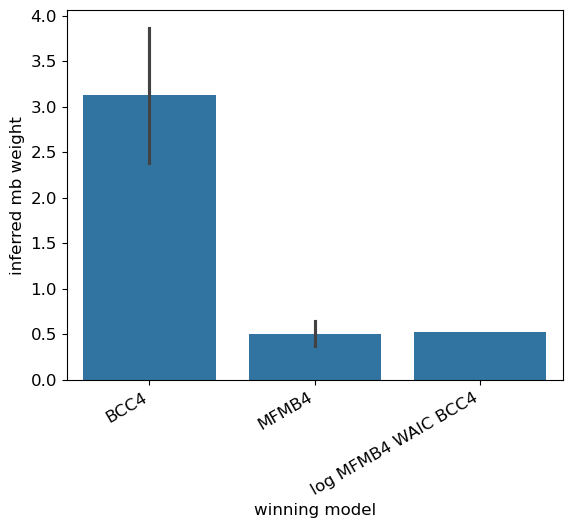

Ns tensor(6) tensor(15) tensor(1) tensor(0)


In [55]:
plot_fontsize = 12

for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True, annotate_pvals=False)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


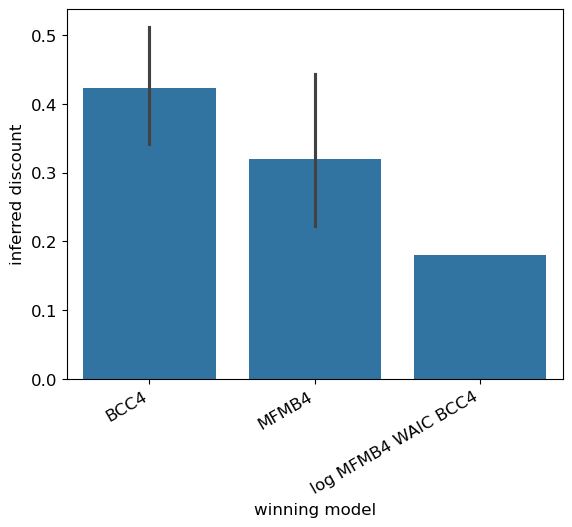

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


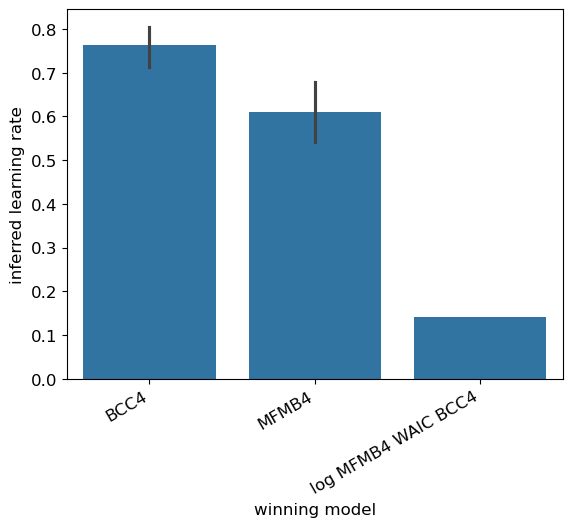

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


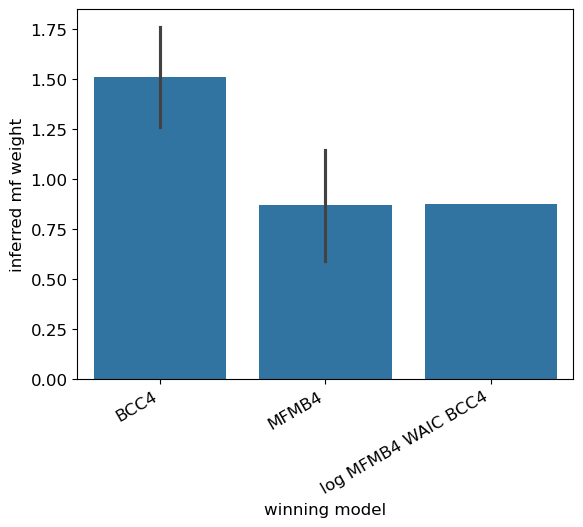

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


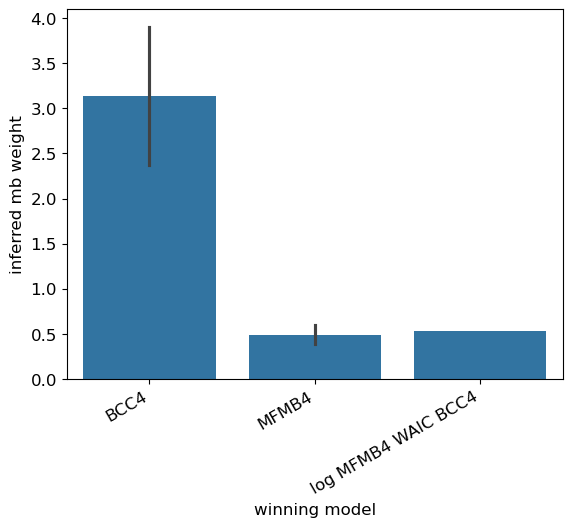

Ns tensor(8) tensor(15) tensor(1) tensor(0)


In [56]:
for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


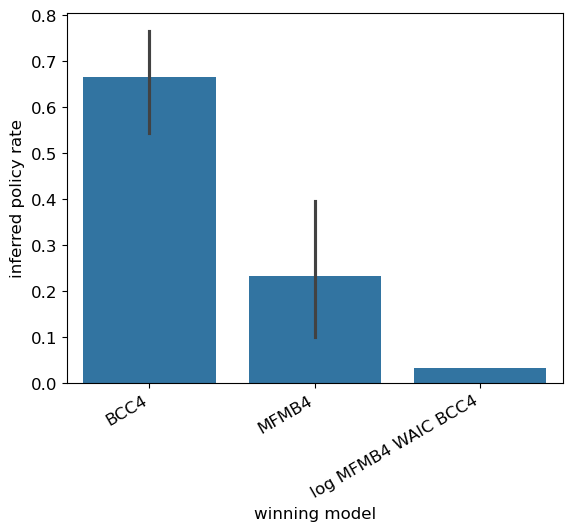

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


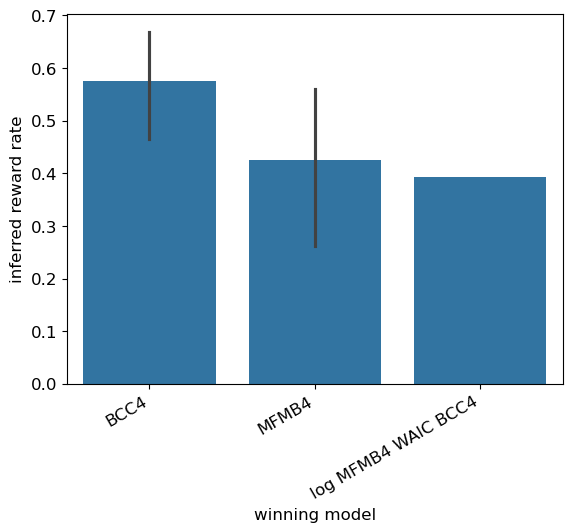

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


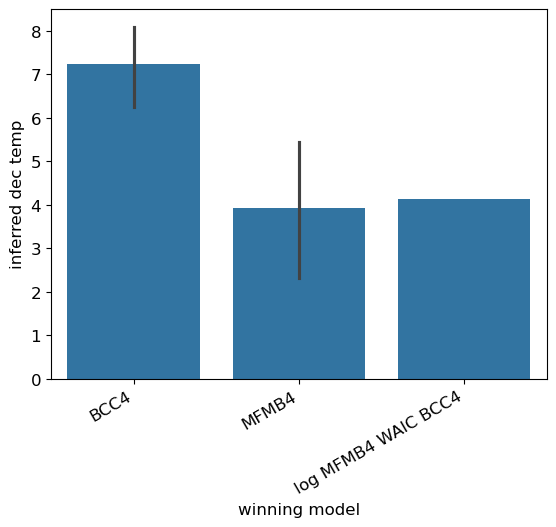

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


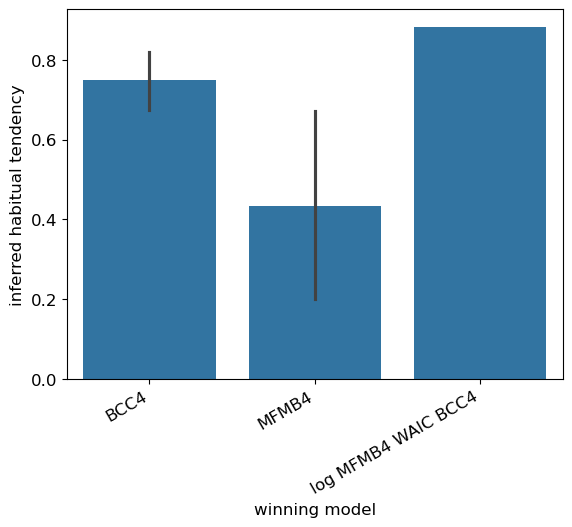

Ns tensor(6) tensor(15) tensor(1) tensor(0)


In [57]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


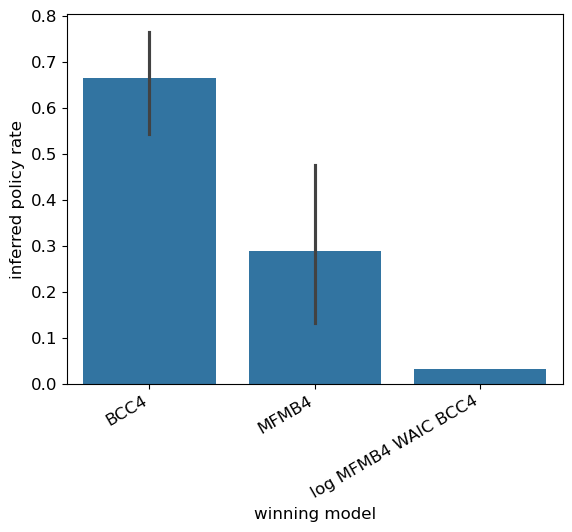

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


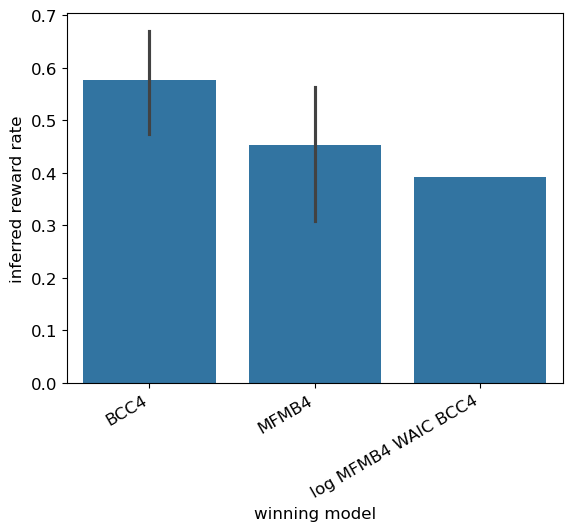

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


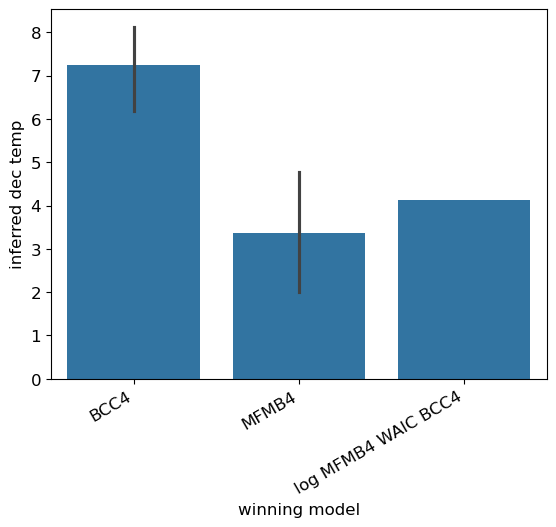

/tmp/ipykernel_8393/2650168456.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')


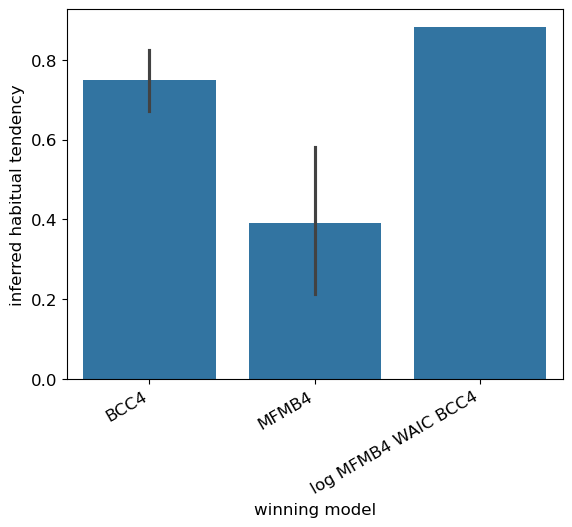

Ns tensor(8) tensor(15) tensor(1) tensor(0)


In [58]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False, fontsize=plot_fontsize)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())

In [59]:
plot_fontsize = 12

for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True, annotate_pvals=True)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

ValueError: `x` and `y` must be of nonzero size.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.714e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.714e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:5.880e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:5.880e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.650e-04
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.650e-04


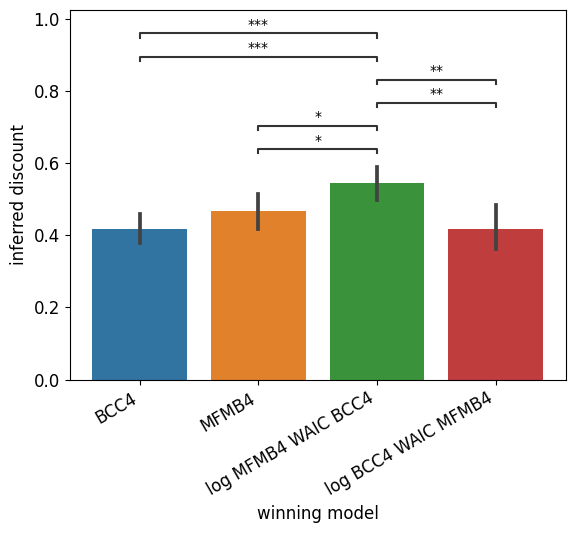

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.135e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.135e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.751e-05
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.751e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.389e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.164e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.389e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.164e-03
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.255e-02
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.255e-02


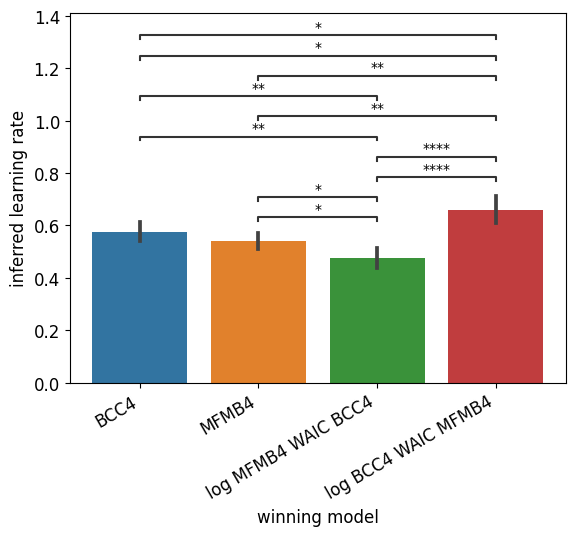

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:8.427e-07
BCC4 vs. MFMB4: Custom statistical test, P_val:8.427e-07
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.403e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.403e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.637e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.637e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.237e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:4.822e-06
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.237e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:4.822e-06


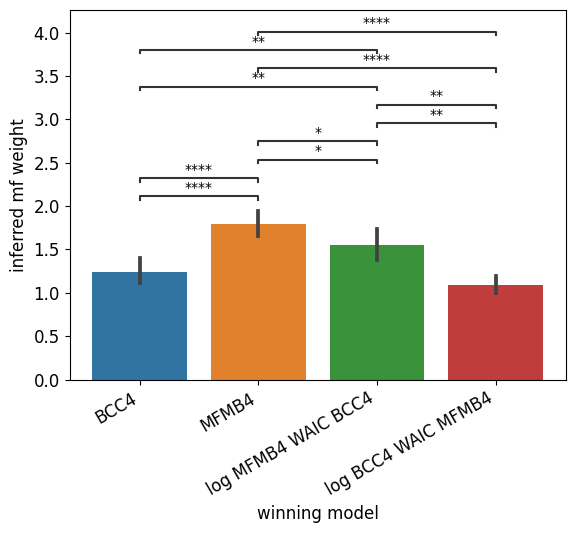

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:7.039e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:7.039e-03


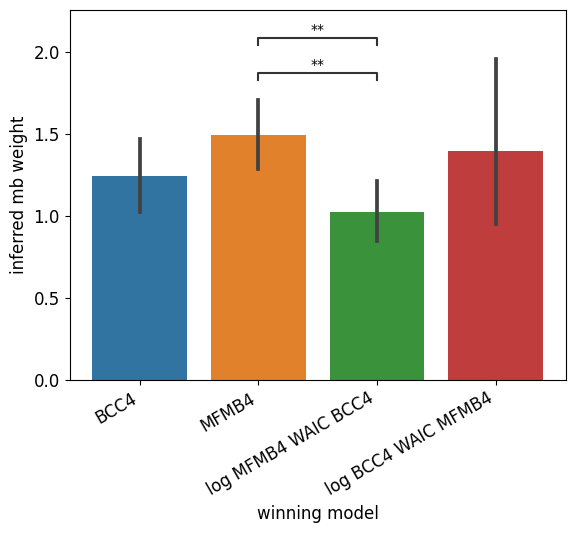

Ns tensor(50) tensor(62) tensor(38) tensor(15)


In [ ]:
plot_fontsize = 12

for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True, annotate_pvals=True)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:2.065e-02
BCC4 vs. MFMB4: Custom statistical test, P_val:2.065e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.700e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.700e-02
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.540e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.540e-05


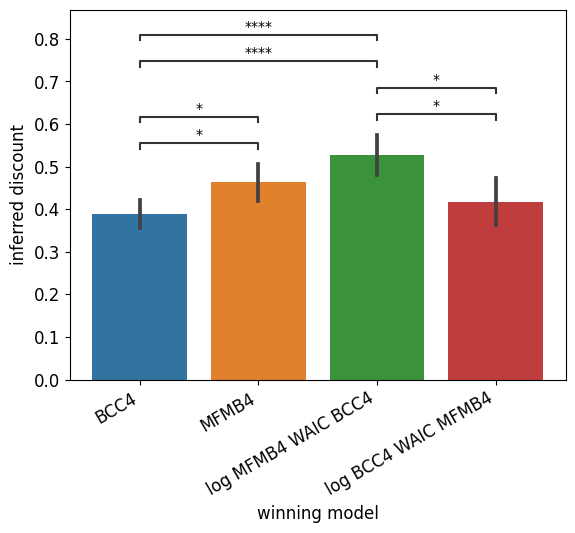

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:2.193e-02
BCC4 vs. MFMB4: Custom statistical test, P_val:2.193e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.386e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:4.386e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.767e-05
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.767e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.981e-04
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.399e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.981e-04
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.399e-03


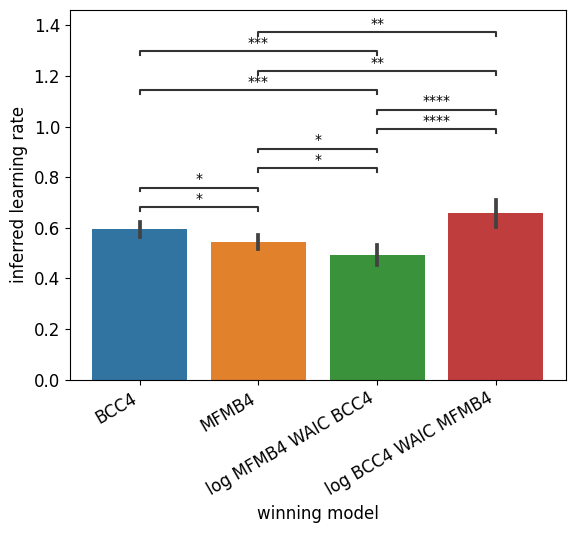

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:9.268e-11
BCC4 vs. MFMB4: Custom statistical test, P_val:9.268e-11
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.310e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.310e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.067e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.067e-02
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:8.014e-05
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:9.656e-06
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:8.014e-05
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:9.656e-06


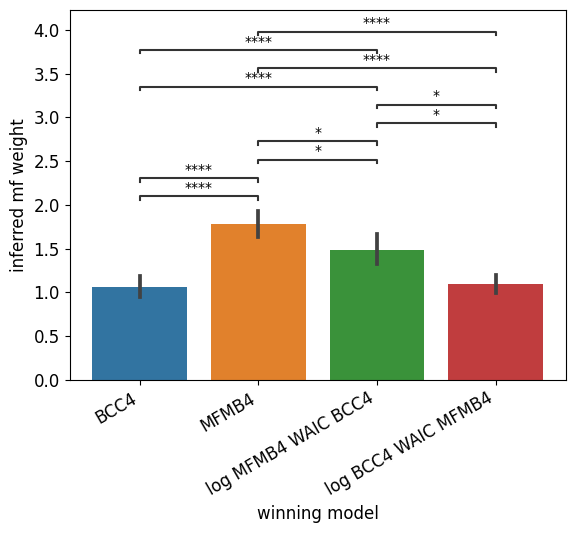

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:1.098e-04
BCC4 vs. MFMB4: Custom statistical test, P_val:1.098e-04
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.265e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.265e-03
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.089e-02
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.089e-02


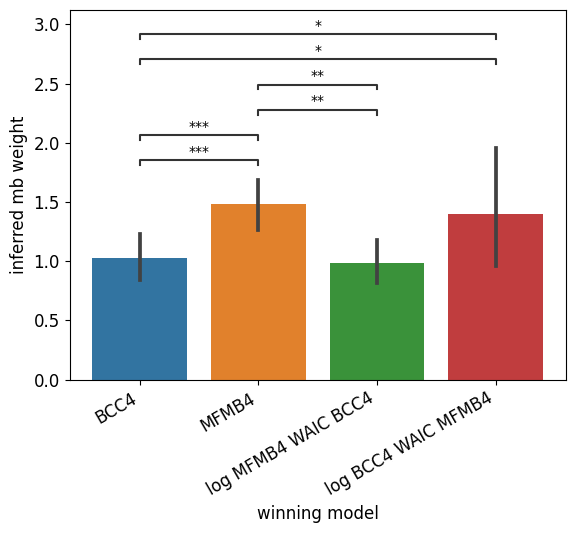

Ns tensor(69) tensor(63) tensor(41) tensor(15)


In [ ]:
for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False, annotate_pvals=True)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:6.324e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:6.324e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.891e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.891e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.419e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.419e-03


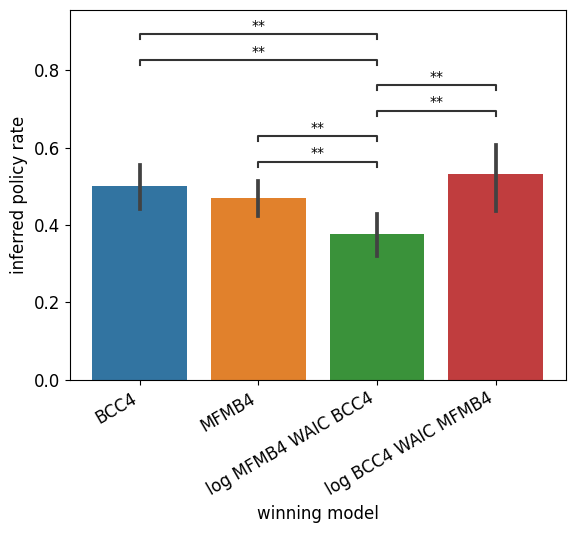

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.178e-05
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.178e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:9.824e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.774e-04
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:9.824e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.774e-04
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.547e-02
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.547e-02


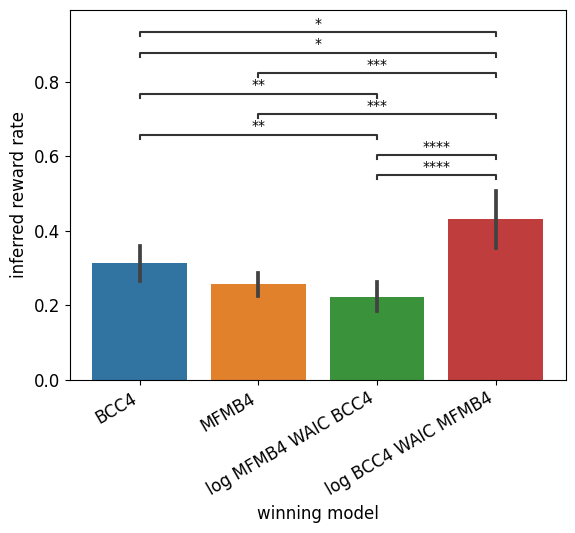

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:7.993e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:7.993e-03


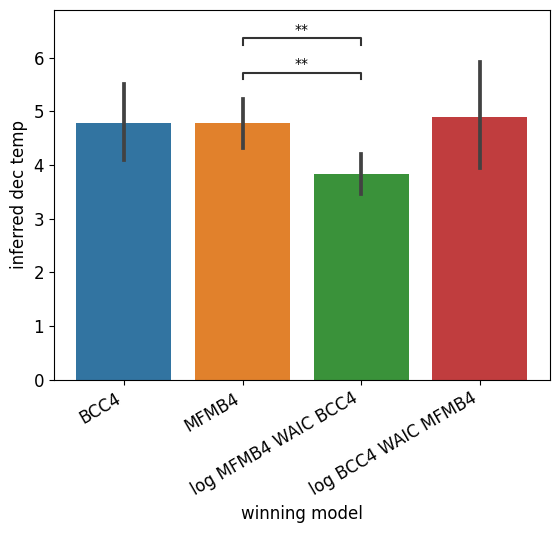

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:7.724e-04
BCC4 vs. MFMB4: Custom statistical test, P_val:7.724e-04
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.235e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.235e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:5.032e-07
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:5.032e-07
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.261e-09
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.076e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.261e-09
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:8.076e-05
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:4.061e-02
BCC4 vs. log BCC4 WAI

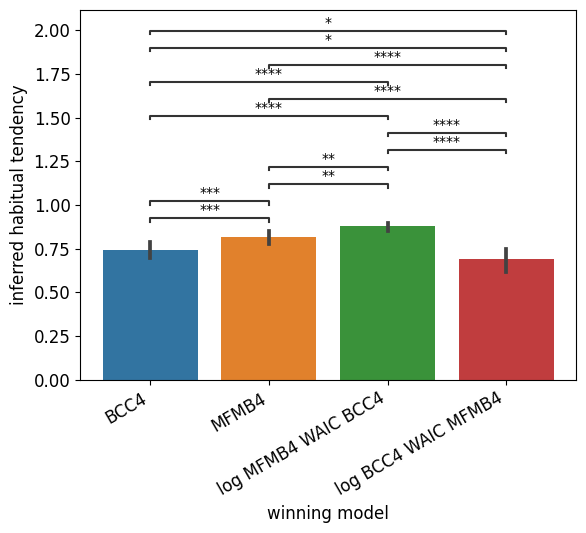

Ns tensor(50) tensor(62) tensor(38) tensor(15)


In [ ]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True, annotate_pvals=True)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.170e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.170e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.460e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.460e-02
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:9.943e-03
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:9.943e-03


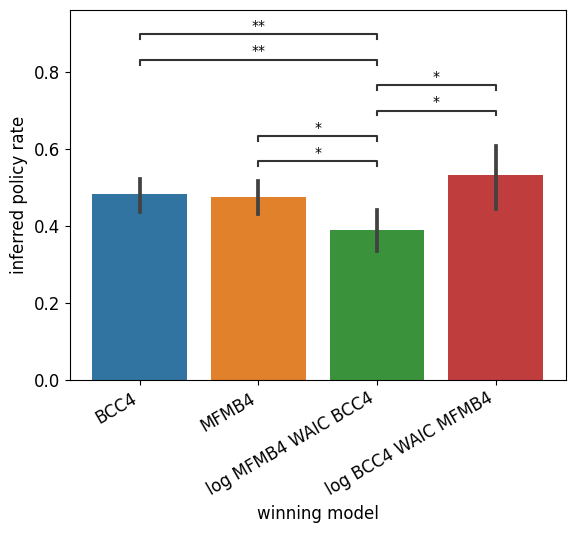

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:1.556e-02
BCC4 vs. MFMB4: Custom statistical test, P_val:1.556e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:4.392e-04
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:4.392e-04
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:6.408e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.662e-04
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:6.408e-03
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.662e-04
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.648e-02
BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.648e-02


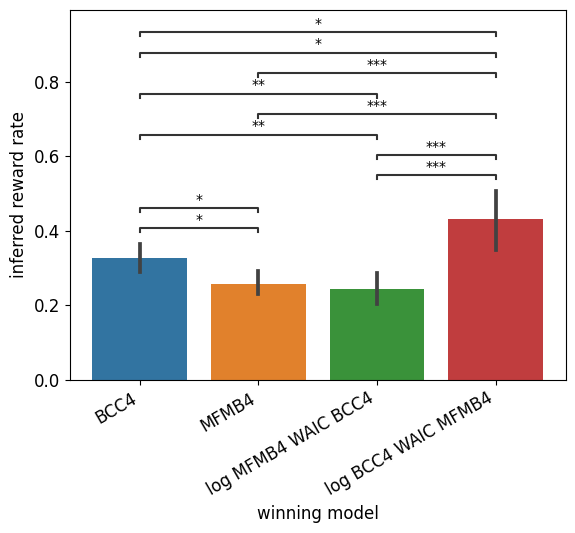

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:6.266e-03
BCC4 vs. MFMB4: Custom statistical test, P_val:6.266e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.010e-03
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:3.010e-03
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.902e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:2.902e-02


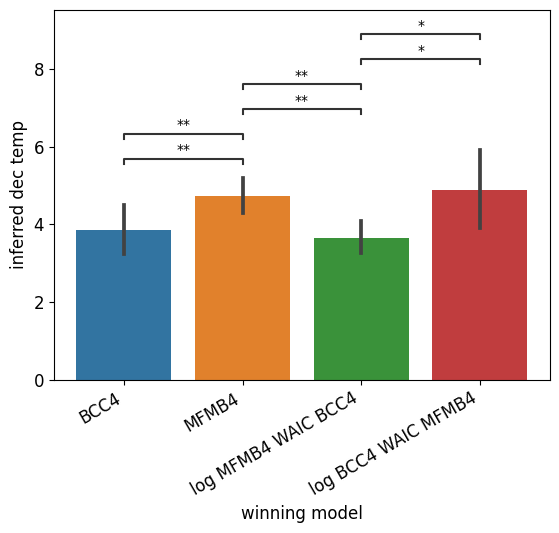

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC4 vs. MFMB4: Custom statistical test, P_val:1.309e-06
BCC4 vs. MFMB4: Custom statistical test, P_val:1.309e-06
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.788e-02
MFMB4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:1.788e-02
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.626e-05
log MFMB4 WAIC BCC4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.626e-05
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.534e-09
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.502e-04
BCC4 vs. log MFMB4 WAIC BCC4: Custom statistical test, P_val:2.534e-09
MFMB4 vs. log BCC4 WAIC MFMB4: Custom statistical test, P_val:1.502e-04


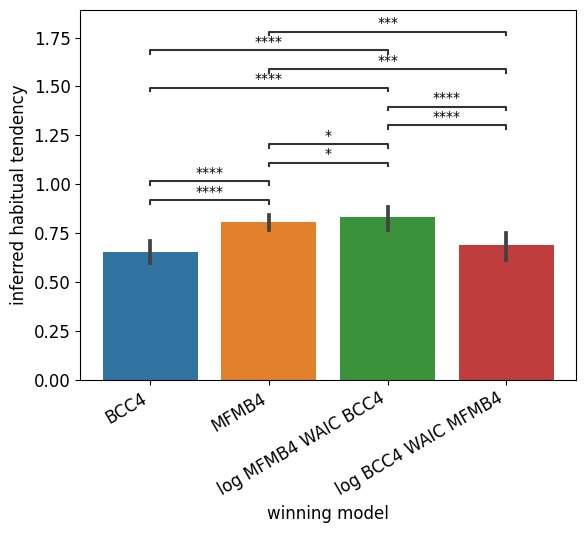

Ns tensor(69) tensor(63) tensor(41) tensor(15)


In [ ]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False, fontsize=plot_fontsize, annotate_pvals=True)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())